<a href="https://colab.research.google.com/github/vivekbasappa/helloworld/blob/master/OLMAR_Strategy_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  15 of 15 completed
<ipython-input-44-d154df71ec86>:197: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  returns_history = pd.concat([returns_history, new_return], ignore_index=True)


Selected Stocks: ['NVDA', 'TSLA', 'AMZN', 'AAPL', 'META', 'GOOGL', 'JPM', 'INTC', 'NFLX', 'CSCO']


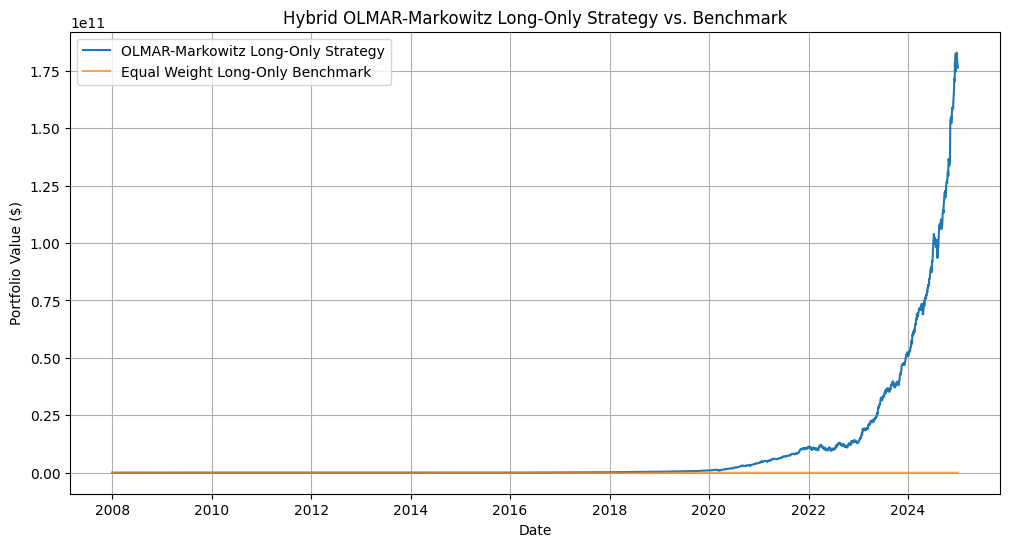

<ipython-input-44-d154df71ec86>:325: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  olmar_final = portfolio['Portfolio Value'][-1]
<ipython-input-44-d154df71ec86>:326: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  benchmark_final = benchmark_df['Benchmark'][-1]


Streaming output truncated to the last 5000 lines.
    META: $7022875587.42
    GOOGL: $1697072287.28
    JPM: $1751817191.15
    INTC: $1756451489.99
    NFLX: $3458732017.15
    CSCO: $1685913476.09

Date: 2023-07-14
  Long Positions:
    NVDA: $6992221733.52
    TSLA: $6882509005.54
    AMZN: $1732757679.57
    AAPL: $1666508051.51
    META: $6971561776.44
    GOOGL: $3469962391.17
    JPM: $1712787489.20
    INTC: $1713771055.09
    NFLX: $1708667546.42
    CSCO: $1677241436.35

Date: 2023-07-17
  Long Positions:
    NVDA: $7074732161.48
    TSLA: $1757229166.64
    AMZN: $1774976121.38
    AAPL: $1711210958.89
    META: $7049988050.97
    GOOGL: $3546382595.73
    JPM: $7017382233.04
    INTC: $1716839846.43
    NFLX: $1712391718.61
    CSCO: $1680998143.86

Date: 2023-07-18
  Long Positions:
    NVDA: $7199275805.14
    TSLA: $1809645415.65
    AMZN: $1763232128.07
    AAPL: $1752611165.06
    META: $7145099928.40
    GOOGL: $1783733630.80
    JPM: $3587849838.42
    INTC: $17905

In [44]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import cvxpy as cp
from datetime import datetime, timedelta

class OLMAR_Markowitz_LongOnly:
    def __init__(self, universe, lookback=10, epsilon=1e-8, risk_aversion=1.0,
                 max_long=0.3, momentum_period=252,
                 volume_period=30, top_n=10, initial_investment=20000):
        """
        Initialize the OLMAR with Markowitz Optimization Long-Only strategy with dynamic stock selection.

        Parameters:
        - universe: List of stock tickers to form the initial universe.
        - lookback: Number of past days to consider for moving average.
        - epsilon: Small constant to prevent division by zero.
        - risk_aversion: Parameter to control the trade-off between return and risk in Markowitz optimization.
        - max_long: Maximum long position per asset.
        - momentum_period: Number of days to calculate momentum (e.g., 252 for ~1 year).
        - volume_period: Number of days to calculate average volume.
        - top_n: Number of top stocks to select based on combined momentum and volume scores.
        - initial_investment: The starting amount of money for the portfolio.
        """
        self.universe = universe
        self.lookback = lookback
        self.epsilon = epsilon
        self.risk_aversion = risk_aversion
        self.max_long = max_long
        self.momentum_period = momentum_period
        self.volume_period = volume_period
        self.top_n = top_n
        self.initial_investment = initial_investment
        self.num_stocks = 0  # Will be updated after stock selection
        self.weights = np.array([])  # Will be initialized after stock selection
        self.weight_history = []
        self.portfolio_values = [initial_investment]  # Start with initial investment
        self.positions_log = []  # To log long positions

    def fetch_data(self, start_date, end_date):
        """
        Fetch historical adjusted close prices for the selected universe.

        Parameters:
        - start_date: Start date for fetching data (YYYY-MM-DD).
        - end_date: End date for fetching data (YYYY-MM-DD).

        Returns:
        - DataFrame of adjusted close prices with missing data handled.
        """
        # Download Adjusted Close Prices and Volume
        data = yf.download(self.universe, start=start_date, end=end_date)
        adj_close = data['Adj Close']
        volume = data['Volume']

        # Ensure the DataFrame has a DateTime index
        if not isinstance(adj_close.index, pd.DatetimeIndex):
            adj_close.index = pd.to_datetime(adj_close.index)
            volume.index = pd.to_datetime(volume.index)

        # Reindex to include all possible trading days within the range
        all_days = pd.date_range(start=start_date, end=end_date, freq='B')  # 'B' for business days
        adj_close = adj_close.reindex(all_days)
        volume = volume.reindex(all_days)

        # Handle missing data
        adj_close = adj_close.ffill().bfill()  # Forward fill, then backward fill
        volume = volume.ffill().bfill()

        # Validation to ensure no missing data remains
        assert not adj_close.isnull().values.any(), "There are still missing values in the adjusted close data after filling."
        assert not volume.isnull().values.any(), "There are still missing values in the volume data after filling."

        return adj_close, volume

    def select_stocks(self, adj_close, volume):
        """
        Select top N stocks based on momentum and volume.

        Parameters:
        - adj_close: DataFrame of adjusted close prices.
        - volume: DataFrame of volume data.

        Returns:
        - List of selected stock tickers.
        """
        # Calculate momentum: past 252 trading days (~1 year) return
        momentum = adj_close.pct_change(periods=self.momentum_period).iloc[-1]

        # Calculate average volume over the past volume_period days
        avg_volume = volume.rolling(window=self.volume_period).mean().iloc[-1]

        # Create a DataFrame for ranking
        ranking_df = pd.DataFrame({
            'Momentum': momentum,
            'AvgVolume': avg_volume
        })

        # Drop stocks with NaN values
        ranking_df.dropna(inplace=True)

        # Rank stocks based on Momentum and AvgVolume
        ranking_df['MomentumRank'] = ranking_df['Momentum'].rank(ascending=False)
        ranking_df['VolumeRank'] = ranking_df['AvgVolume'].rank(ascending=False)

        # Combine ranks (you can adjust weights if desired)
        ranking_df['CombinedScore'] = ranking_df['MomentumRank'] + ranking_df['VolumeRank']

        # Select top N stocks with lowest CombinedScore
        selected = ranking_df.nsmallest(self.top_n, 'CombinedScore').index.tolist()

        self.num_stocks = len(selected)
        return selected

    def markowitz_optimize(self, returns_history, max_long=0.3):
        """
        Perform Markowitz Portfolio Optimization to determine optimal weights.

        Parameters:
        - returns_history: DataFrame of historical returns.
        - max_long: Maximum allowed long position per asset.

        Returns:
        - Optimal weights as a NumPy array.
        """
        # Calculate expected returns and covariance matrix
        expected_returns = returns_history.mean().values
        cov_matrix = returns_history.cov().values

        # Define optimization variables
        w = cp.Variable(self.num_stocks)

        # Define the objective: Maximize expected return - risk_aversion * portfolio variance
        objective = cp.Maximize(expected_returns @ w - self.risk_aversion * cp.quad_form(w, cov_matrix))

        # Constraints:
        constraints = [
            cp.sum(w) == 1,                # Fully invested portfolio
            w >= 0,                        # No short positions
            w <= max_long                  # Limit long positions per asset
        ]

        # Define and solve the problem
        prob = cp.Problem(objective, constraints)
        prob.solve()

        if w.value is not None:
            optimal_weights = np.array(w.value).flatten()
        else:
            # If optimization fails, revert to equal weights
            optimal_weights = np.array([1.0 / self.num_stocks] * self.num_stocks)

        return optimal_weights

    def run(self, adj_close, volume):
        """
        Run the hybrid OLMAR-Markowitz long-only strategy on the provided data.

        Parameters:
        - adj_close: DataFrame of adjusted close prices.
        - volume: DataFrame of volume data.

        Returns:
        - DataFrame with portfolio value over time.
        - DataFrame with positions log.
        """
            # Initial stock selection
        selected_stocks = self.select_stocks(adj_close, volume)
        print(f"Selected Stocks: {selected_stocks}")
        selected_adj_close = adj_close[selected_stocks]
        selected_volume = volume[selected_stocks]

        # Initialize weights as equal weights
        self.weights = np.array([1.0 / self.num_stocks] * self.num_stocks)
        self.weight_history = [self.weights.copy()]
        self.portfolio_values = [self.initial_investment]

        # Calculate daily returns
        returns = selected_adj_close.pct_change().dropna().copy()
        num_days, num_stocks = returns.shape

        # To store historical returns for Markowitz
        returns_history = pd.DataFrame(columns=selected_stocks)

        for t in range(num_days):
            current_date = returns.index[t]
            if t < self.lookback:
                # Not enough data to compute moving average; keep initial weights
                portfolio_return = np.dot(self.weights, returns.iloc[t].values)
                new_portfolio_value = self.portfolio_values[-1] * (1 + portfolio_return)
                self.portfolio_values.append(new_portfolio_value)
                self.weight_history.append(self.weights.copy())

                # Update returns history using pd.concat
                new_return = returns.iloc[t].to_frame().T
                returns_history = pd.concat([returns_history, new_return], ignore_index=True)

                # Log positions (only long positions)
                longs = [(stock, weight * new_portfolio_value) for stock, weight in zip(selected_stocks, self.weights) if weight > 0]
                self.positions_log.append({
                    'Date': current_date,
                    'Longs': longs
                })

                continue

            # Update returns history
            new_return = returns.iloc[t].to_frame().T
            returns_history = pd.concat([returns_history, new_return], ignore_index=True)

            if len(returns_history) > self.lookback:
                returns_history = returns_history.iloc[1:].reset_index(drop=True)

            # Compute moving average of past 'lookback' days
            past_prices = selected_adj_close.iloc[t - self.lookback:t].values
            mean_prices = np.mean(past_prices, axis=0)
            current_prices = selected_adj_close.iloc[t].values
            # Calculate relative prices (current / mean)
            relative_prices = current_prices / (mean_prices + self.epsilon)

            # Normalize relative prices to form a reference portfolio
            reference_portfolio = relative_prices / (np.sum(relative_prices) + self.epsilon)

            # OLMAR weight adjustment: Move towards the reference portfolio
            olmar_weights = reference_portfolio
            olmar_weights = np.clip(olmar_weights, 0, self.max_long)  # Enforce individual long limits
            # Normalize to ensure sum of weights equals 1
            olmar_weights /= (np.sum(olmar_weights) + self.epsilon)

            # Markowitz optimization based on historical returns
            markowitz_weights = self.markowitz_optimize(returns_history,
                                                       max_long=self.max_long)

            # Combine OLMAR and Markowitz weights
            # Weighted average favoring equally both strategies
            combined_weights = 0.5 * olmar_weights + 0.5 * markowitz_weights
            # Normalize to maintain full investment
            combined_weights /= (np.sum(combined_weights) + self.epsilon)

            # Update portfolio weights
            self.weights = combined_weights

            # Calculate portfolio return
            portfolio_return = np.dot(self.weights, returns.iloc[t].values)
            new_portfolio_value = self.portfolio_values[-1] * (1 + portfolio_return)

            # Update history
            self.portfolio_values.append(new_portfolio_value)
            self.weight_history.append(self.weights.copy())

            # Log positions
            longs = [(stock, weight * new_portfolio_value) for stock, weight in zip(selected_stocks, self.weights) if weight > 0]
            self.positions_log.append({
                'Date': current_date,
                'Longs': longs
            })

        portfolio_df = pd.DataFrame({
            'Portfolio Value': self.portfolio_values[1:]
        }, index=returns.index)

        # Create Positions Log DataFrame
        positions_log_df = pd.DataFrame(self.positions_log)
        return portfolio_df, positions_log_df

def main():
    # Define the initial universe of stocks (e.g., S&P 500 components)
    # For demonstration, we'll use a smaller subset. Replace with a comprehensive list as needed.
    selected_universe = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'JPM', 'V', 'DIS', 'NFLX', 'INTC', 'CSCO', 'ADBE', 'PYPL']

    # Initialize Hybrid OLMAR-Markowitz Long-Only strategy with dynamic stock selection
    olmar_markowitz = OLMAR_Markowitz_LongOnly(
        universe=selected_universe,
        lookback=10,
        risk_aversion=1.0,
        max_long=0.3,
        momentum_period=252,  # Approximately 1 year
        volume_period=30,
        top_n=10,  # Number of top stocks to select
        initial_investment=20000  # Set initial investment to $20,000
    )

    # Fetch historical data
    start_date = '2008-01-01'
    end_date = '2025-01-01'  # Adjust as needed
    adj_close, volume = olmar_markowitz.fetch_data(start_date, end_date)

    # Run the hybrid strategy
    portfolio, positions_log = olmar_markowitz.run(adj_close, volume)

    # Fetch benchmark (e.g., equally weighted long-only portfolio)
    # Construct a long-only benchmark with full investment
    selected_stocks = olmar_markowitz.select_stocks(adj_close, volume)
    if len(selected_stocks) == 0:
        print("No stocks selected for benchmark.")
        return

    # Calculate equal weights for benchmark
    equal_weight = 1.0 / len(selected_stocks)
    benchmark_weights = np.array([equal_weight] * len(selected_stocks))

    # Calculate benchmark returns
    benchmark_returns = adj_close[selected_stocks].pct_change().dropna().dot(benchmark_weights)
    benchmark_values = olmar_markowitz.initial_investment * (1 + benchmark_returns).cumprod()
    benchmark_df = pd.DataFrame({
        'Benchmark': benchmark_values
    }, index=adj_close[selected_stocks].pct_change().dropna().index)

    # Align portfolio and benchmark dates
    comparison = pd.concat([portfolio, benchmark_df], axis=1).dropna()

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(comparison.index, comparison['Portfolio Value'], label='OLMAR-Markowitz Long-Only Strategy')
    plt.plot(comparison.index, comparison['Benchmark'], label='Equal Weight Long-Only Benchmark', alpha=0.7)
    plt.title('Hybrid OLMAR-Markowitz Long-Only Strategy vs. Benchmark')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Performance Metrics
    olmar_final = portfolio['Portfolio Value'][-1]
    benchmark_final = benchmark_df['Benchmark'][-1]
    num_trading_days = len(portfolio)
    olmar_cagr = (olmar_final / olmar_markowitz.initial_investment) ** (252 / num_trading_days) - 1  # Approximate CAGR
    benchmark_cagr = (benchmark_final / olmar_markowitz.initial_investment) ** (252 / num_trading_days) - 1
    print(f"Final Portfolio Value (OLMAR-Markowitz Long-Only): ${olmar_final:.2f}")
    print(f"Final Benchmark Value: ${benchmark_final:.2f}")
    print(f"Approximate CAGR (OLMAR-Markowitz Long-Only): {olmar_cagr * 100:.2f}%")
    print(f"Approximate CAGR (Benchmark): {benchmark_cagr * 100:.2f}%")

    # Display Positions Log
    print("\nPositions Log:")
    for index, row in positions_log.iterrows():
        date = row['Date'].strftime('%Y-%m-%d')
        longs = row['Longs']
        print(f"\nDate: {date}")
        if longs:
            print("  Long Positions:")
            for stock, amount in longs:
                print(f"    {stock}: ${amount:.2f}")
        else:
            print("  Long Positions: None")

    # Optionally, save the positions log to a CSV file
    positions_log.to_csv('positions_log_long_only.csv', index=False)
    print("\nPositions log saved to 'positions_log_long_only.csv'.")

if __name__ == "__main__":
    main()
